In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from nltk.corpus import stopwords


import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, GRU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner import BayesianOptimization

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score
)
from sklearn.model_selection import train_test_split


from text_classification.paths import DATA_DIR, MODELS_DIR
import text_classification.config as cfg
from text_classification.analytics import clean_text
from text_classification.plots import (
    plot_training_history, plot_f1_scores_vs_thresholds, plot_confusion_matrix, plot_roc_curve
)

# Download stopwords and lemmatizer data if necessary
# nltk.download('stopwords')
# nltk.download('wordnet')

%matplotlib inline

In [3]:
# Check if MPS is available
if tf.config.list_physical_devices('GPU'):
    print("MPS backend is available and will be used.")
else:
    print("MPS backend is not available. Using CPU instead.")

MPS backend is available and will be used.


In [4]:
# Use constants from config.py
vocab_size = cfg.MAX_FREQ_WORDS
embedding_dim = cfg.MAX_EMBEDDINGS_DIM

In [5]:
# Load data 
data = pd.read_csv(DATA_DIR / 'historical_data.csv')

# Load new data
new_data = pd.read_csv(DATA_DIR / 'new_data.csv')

In [6]:
# train overview
data.head()

,Review.Text,Recommended.IND
0,This top runs large. i had no problem sizing d...,1
1,"I love the black and pale pink of this dress, ...",1
2,"Great quality, beautiful print, definitely a s...",1
3,I bought these in a few different colors becau...,1
4,This dress fits well and the material allows f...,1


In [7]:
# Basic information about the dataset
data.info()

# Check the proportions of the target variable
data['Recommended.IND'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review.Text      4500 non-null   object
 1   Recommended.IND  4500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.4+ KB


Recommended.IND
1    0.820889
0    0.179111
Name: proportion, dtype: float64

In [8]:
# Rename the columns
data = (
    data
    .rename(columns={'Recommended.IND': 'recommended', 'Review.Text': 'review'})
)

In [9]:
# Load from the text file negations
with open(Path(DATA_DIR / 'negations.txt'), 'r') as file:
    negations = [line.strip() for line in file]

In [10]:
# Apply the cleaning function to the review text column
data['cleaned_review'] = data['review'].apply(lambda x: clean_text(x, negations))

# Apply the cleaning function to the review text column
new_data['cleaned_review'] = new_data['Review.Text'].apply(lambda x: clean_text(x, negations))

In [11]:
# Calculate the number of characters per line in the 'review' and 'cleaned_review' columns
data['review_char_count'] = data['review'].str.len()
data['cleaned_review_char_count'] = data['cleaned_review'].str.len()

# Print the first few rows to verify the new columns
data.head()

,review,recommended,cleaned_review,review_char_count,cleaned_review_char_count
0,This top runs large. i had no problem sizing d...,1,top run large not_problem not_sizing one size ...,502,339
1,"I love the black and pale pink of this dress, ...",1,love black pale pink dress contrasting fabric ...,500,293
2,"Great quality, beautiful print, definitely a s...",1,great quality beautiful print definitely steal...,148,118
3,I bought these in a few different colors becau...,1,bought different color comfortable perfect sum...,200,107
4,This dress fits well and the material allows f...,1,dress fit well material allows hiding lump bum...,427,272


Graphs with number of words and compare distributions

In [12]:
# Define X, y variables to be split into training and testing sets being X explicitly defined
X = data.drop(columns=['recommended', 'review', 'review_char_count', 'cleaned_review_char_count'])

# Target variable
y = data['recommended']

In [13]:
# Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.20, 
    stratify=y,
    random_state=123
)

In [14]:
# Ensure X_train and X_val contain the text data
X_train_text = X_train['cleaned_review'].tolist()  
X_val_text = X_val['cleaned_review'].tolist()      

# Tokenization parameters
max_words = cfg.MAX_FREQ_WORDS # 2500
max_length = cfg.MAX_WORDS_PER_TEXT # 60 

# Initialize the tokenizer and fit it on the training data (on the actual text)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train_text)  # Fit tokenizer on the list of cleaned reviews

# Convert the training and validation sets to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)

# Pad the sequences to ensure uniform input length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

In [15]:
# Calculate  classes weights
classes = np.unique(y_train)

# Compute the classes weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

# Store in a dictionary to fit the model
class_weight_dict = dict(zip(classes, class_weights))

# Define aditional class weights
class_weight_options = [
    class_weight_dict,
    {0: 10.0, 1: 0.2},
    {0: 4.0, 1: 0.5},
    {0: 5.0, 1: 1.22}
]

In [16]:
# Build model function for Bayesian Optimization
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=2500, 
                        output_dim=100, 
                        # input_length=60,
                        trainable=True))

    # Choose weight initializer
    weight_initializer = hp.Choice('weight_initializer', values=['he_normal', 'glorot_uniform', 'lecun_normal'])

    # 1D Convolutional Layer with L2 regularization and padding
    model.add(Conv1D(filters=hp.Int('conv_filters', min_value=16, max_value=264, step=16),
                     kernel_size=hp.Choice('conv_kernel_size', values=[3, 5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                     kernel_initializer=weight_initializer))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layer with L2 regularization
    model.add(LSTM(units=hp.Int('lstm_units', min_value=16, max_value=264, step=16),
                   return_sequences=True,
                   kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                   kernel_initializer=weight_initializer))
 
    model.add(Bidirectional(GRU(units=hp.Int('gru_units', min_value=16, max_value=264,step=16),    
                            return_sequences=False)))  # Change return_sequences based on architecture needs
    
    model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=264, step=16),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_lambda', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                    kernel_initializer=weight_initializer))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)))   
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid', kernel_initializer=weight_initializer))

    # Choose optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    # Dynamically select class weights
    class_weight_index = hp.Choice('class_weight_index', [0, 1, 2, 3])  # Add this line to define class weight index
    class_weight = class_weight_options[class_weight_index]

    # Compile the model
    model.compile(optimizer=optimizer_instance,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [17]:
# Initialize the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory=Path(MODELS_DIR / 'tuner'),
    project_name='bayes_opt'
)

# Define the search space
tuner.search_space_summary()

Reloading Tuner from /Users/borja/Documents/Somniumrema/projects/ml/text_classification/models/tuner/bayes_opt/tuner0.json
Search space summary
Default search space size: 11
weight_initializer (Choice)
{'default': 'he_normal', 'conditions': [], 'values': ['he_normal', 'glorot_uniform', 'lecun_normal'], 'ordered': False}
conv_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
conv_kernel_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
l2_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
gru_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 264, '

2024-09-09 03:19:08.295762: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-09 03:19:08.295786: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-09 03:19:08.295790: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-09 03:19:08.295806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-09 03:19:08.295818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [18]:
# Use the tuner to search the hyperparameter space, but now pass the class weights dynamically inside the search loop
tuner.search(
    X_train_pad, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_pad, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    # Class weights will be selected dynamically within the model, no need to pass here
)

In [19]:
# Get the best hyperparameters after tuning
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best class weight index
best_class_weight_index = best_hps.get('class_weight_index')

# Retrieve the corresponding class weight dictionary
best_class_weight = class_weight_options[best_class_weight_index]

print(f"The best class weight is: {best_class_weight}")

The best class weight is: {0: 4.0, 1: 0.5}


In [20]:
# Ensure the target variable is in the correct format
y_train = np.array(y_train)
y_val = np.array(y_val)

# Build the model using the best hyperparameters
model = build_model(best_hps)

# Define early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5, 
                               restore_best_weights=True
                               )

In [34]:
# Train the model with the best hyperparameters and appropriate class weights
history = model.fit(
    X_train_pad, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9919 - loss: 0.2504 - val_accuracy: 0.8511 - val_loss: 0.9140
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9965 - loss: 0.1976 - val_accuracy: 0.8544 - val_loss: 0.9285
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9937 - loss: 0.1804 - val_accuracy: 0.8544 - val_loss: 0.9276
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9965 - loss: 0.1496 - val_accuracy: 0.8544 - val_loss: 0.7572
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9978 - loss: 0.1296 - val_accuracy: 0.8511 - val_loss: 0.9202
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9999 - loss: 0.1109 - val_accuracy: 0.8522 - val_loss: 0.9055
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9998 - loss: 0.1003 - val_accuracy: 0.8511 - val_loss: 0.9112
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9990 - loss: 0.0937 - val_acc

In [22]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 60, 100)        │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 64)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 96)         │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,119,221 (4.27 MB)

 Trainable params: 373,073 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 746,148 (2.85 MB)

In [23]:
# Plot the training history
plot_training_history(history)

In [24]:
# Serialize the trained model
model.save(MODELS_DIR / 'lstm3.keras') 

# Load the saved model
tc_model = tf.keras.models.load_model(MODELS_DIR / 'lstm3.keras')

In [25]:
# Predict probabilities for the validation set
y_pred_prob = tc_model.predict(X_val_pad)

# Define a range of threshold values
thresholds = np.arange(0.0, 1.1, 0.1)

# Calculate F1 scores for each threshold using list comprehension
f1_scores = [f1_score(y_val, (y_pred_prob >= threshold).astype(int)) for threshold in thresholds]

# Find the threshold that gives the best F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [26]:
# Plot F1 scores vs. thresholds
plot_f1_scores_vs_thresholds(thresholds, f1_scores, best_threshold)

In [27]:
# Binary classification
y_pred_prob = tc_model.predict(X_val_pad)
y_pred = (y_pred_prob > best_threshold).astype(int)

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [28]:
# Print the classification report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       161
           1       0.89      0.94      0.92       739

    accuracy                           0.86       900
   macro avg       0.76      0.70      0.72       900
weighted avg       0.84      0.86      0.85       900



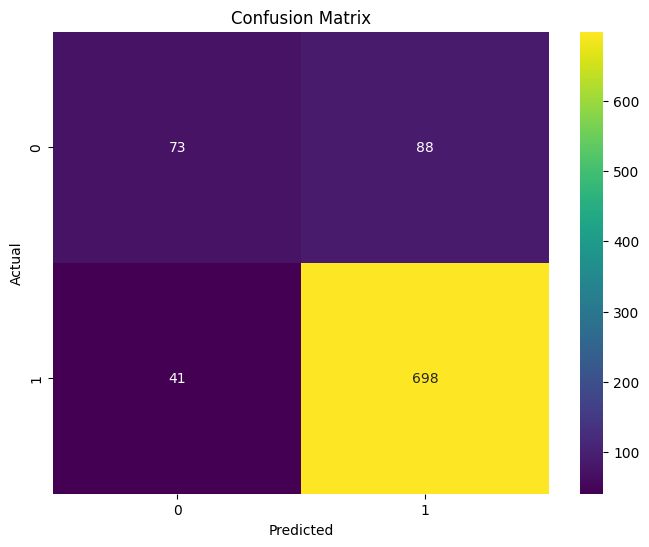

In [29]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(conf_matrix)

In [30]:
# Plot the ROC curve
plot_roc_curve(y_val, y_pred_prob)

In [31]:
# Convert the new data to sequences of integers
new_data_seq = tokenizer.texts_to_sequences(new_data['cleaned_review'])
new_data_pad = pad_sequences(new_data_seq, maxlen=max_length, padding='post')

# Make predictions on the new data
new_dats_pred_proba = tc_model.predict(new_data_pad)
new_data['recommended_predicted'] = (new_dats_pred_proba > best_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [32]:
# Prepare the new dataset
new_data.drop(columns=['cleaned_review'], inplace=True)

# Save the new dataset with predictions
new_data.to_csv(DATA_DIR / 'new_data_w_preds.csv', index=False)

In [33]:
# Clear the TensorFlow Keras session
tf.keras.backend.clear_session()